In [43]:
import pandas as pd
import geopandas as gpd
from geopandas import GeoDataFrame
from pandas import DataFrame
from pathlib import Path
from topojson import Topology

from shapely.geometry import Polygon

def process_dep(dep : int, bv_gdf : GeoDataFrame, ci_gdf : GeoDataFrame, bv_df : DataFrame, ci_df : DataFrame, election : str, t=0.001) -> None:
    print(f'Processing {dep}...')
    dep_str = str(dep).zfill(2)
    dep_bv_gdf = bv_gdf[bv_gdf['bv_id'].str.startswith(dep_str)].copy()
    dep_ci_gdf = ci_gdf[ci_gdf['dep'] == dep_str].copy()
    dep_bv_df = bv_df[bv_df['Code département'] == dep].copy()
    dep_ci_df = ci_df[ci_df['Code département'] == dep].copy()

    print(f'Filtering invalid geoms {dep}...')
    dep_bv_gdf.geometry = dep_bv_gdf.geometry.make_valid()
    dep_bv_gdf = dep_bv_gdf[dep_bv_gdf.is_valid]
    print(f'Simplifying {dep}...')
    
    topo : GeoDataFrame | None = None
    try:
        initial_crs = dep_bv_gdf.crs
        dep_bv_gdf.geometry = dep_bv_gdf.geometry.make_valid().to_crs(epsg=2154).buffer(0.00001)
        geojson_data = dep_bv_gdf.__geo_interface__
        #EPSG3857
        # Create Topology and simplify
        topo = Topology(data=geojson_data, toposimplify=t).to_gdf()
        # Re-project back to the original CRS if needed
        topo = topo.set_crs(epsg=2154).to_crs(initial_crs)
        topo.set_index('bv_id', drop=True, inplace=True)
        topo.drop(columns=[c for c in topo.columns if c != 'geometry'], inplace=True)
        topo.geometry = topo.geometry.make_valid()
        
        def convert_to_polygon(geometry):
            if geometry.geom_type == 'Polygon':
                return geometry
            elif geometry.geom_type == 'MultiPolygon':
                # Return the largest polygon by area
                return geometry
                #return max(geometry, key=lambda a: a.area)
            elif geometry.geom_type == 'GeometryCollection':
                # Extract polygons from GeometryCollection
                polygons = [geom for geom in geometry.geoms if isinstance(geom, Polygon)]
                if polygons:
                    return max(polygons, key=lambda a: a.area)
            return None
        topo['geometry'] = topo['geometry'].apply(convert_to_polygon)

    except Exception as e:
        print(e)

    
    dep_bv_df['bv_id'] = dep_bv_df['Code commune'].astype(str) + '_' + dep_bv_df['Code BV'].astype(str)
    dep_ci_df['ci_id'] = dep_ci_df['id_circo'].astype(str)
    dep_ci_df = dep_ci_df.drop(columns=['id_circo'])
    dep_ci_gdf['ci_id'] = dep_ci_gdf['id_circo'].astype(str)
    dep_ci_gdf = dep_ci_gdf.drop(columns=['id_circo'])

    print(f'Saving {dep}...')
    output_dir = Path(f'~/workspace/carto_legislatives_2024//départements/{dep}').expanduser()
    output_dir.mkdir(parents=True, exist_ok=True)
    if topo is not None:
        topo.to_file(output_dir / Path(f'bureaux_votes_{dep}.gpkg'), driver='GPKG')
        print('topo')
        print(topo.is_valid.all())
        print(topo[~topo.is_valid])
    else :
        dep_bv_gdf.to_file(output_dir / Path(f'bureaux_votes_{dep}.gpkg'), driver='GPKG')
        print(dep_bv_gdf.is_valid.all())
        print(dep_bv_gdf[~dep_bv_gdf.is_valid])
    dep_ci_gdf.to_file(output_dir / Path(f'circonscriptions_{dep}.gpkg'), driver='GPKG')
    dep_bv_df.to_excel(output_dir / Path(f'{election}_bureaux_votes_{dep}.xlsx'), index=False)
    dep_ci_df.to_excel(output_dir / Path(f'{election}_circonscriptions_{dep}.xlsx'), index=False)

In [27]:
import geopandas as gpd
from pathlib import Path
import pandas as pd
from topojson import Topology
from shapely.geometry import Point, GeometryCollection, Polygon

def process_simple_dep(dep, bv_gdf, ci_gdf, bv_df, ci_df, election, t=0.001):
    print(f'Processing {dep}...')

    #dep_bv_gdf = bv_gdf[bv_gdf['bv_id'].str.startswith(str(dep))].copy()
    dep_str = str(dep).zfill(2)
    dep_bv_gdf = bv_gdf[bv_gdf['bv_id'].str.startswith(dep_str)].copy()
    dep_ci_gdf = ci_gdf[ci_gdf['dep'] == dep_str].copy()
    dep_bv_df = bv_df[bv_df['Code département'] == dep].copy()
    dep_ci_df = ci_df[ci_df['Code département'] == dep].copy()
    
    # MERGING BV
    # geometries bv_id
    dep_bv_gdf['bv_id'] = bv_gdf['bv_id'].astype(str)
    if len(str(dep)) == 1:
        dep_bv_df['bv_id'] = dep_str + dep_bv_df['Code commune'].astype(str).str[1:] + '_' + dep_bv_df['Code BV'].astype(str)
    else:
        dep_bv_df['bv_id'] = dep_bv_df['Code commune'].astype(str) + '_' + dep_bv_df['Code BV'].astype(str)
    
    dep_bv_df['Code commune'] = dep_bv_df['Code commune'].astype(str)
    

    bv_merged_gdf = dep_bv_gdf.merge(dep_bv_df, on='bv_id')
    original_row_count = min(len(dep_bv_gdf), len(dep_bv_df))
    merged_row_count = len(bv_merged_gdf)
    print(f'Merging BV {original_row_count} -> {merged_row_count}')

    
    # MERGING CI
    dep_ci_df['ci_id'] = dep_ci_df['id_circo'].astype(str).str.zfill(4)
    dep_ci_df = dep_ci_df.drop(columns=['id_circo'])
    
    dep_ci_gdf['ci_id'] = dep_ci_gdf['id_circo'].astype(str)
    dep_ci_gdf = dep_ci_gdf.drop(columns=['id_circo'])
    
    ci_merged_gdf = dep_ci_gdf.merge(dep_ci_df, on='ci_id')
    original_row_count = min(len(dep_ci_gdf), len(dep_ci_df))
    merged_row_count = len(ci_merged_gdf)
    print(f'Merging CI {original_row_count} -> {merged_row_count}')

    #bv_merged_gdf.geometry = bv_merged_gdf.geometry.make_valid()
    #print(f'{sum(~(dep_bv_gdf.is_valid & ~dep_bv_gdf.is_empty))}/{len(dep_bv_gdf)} filtered geoms')
    #dep_bv_gdf = dep_bv_gdf[dep_bv_gdf.is_valid & ~dep_bv_gdf.is_empty]

    filter = bv_merged_gdf.is_valid & bv_merged_gdf.geometry.notna()
    print(f'Filtering geoms {len(bv_merged_gdf)} -> {sum(filter)}')
    #dep_bv_gdf = dep_bv_gdf[dep_bv_gdf.is_valid & dep_bv_gdf.geometry.notna()]
    bv_merged_gdf = bv_merged_gdf[bv_merged_gdf.is_valid & bv_merged_gdf.geometry.notna()]
    
    if t > 0:
        print(f'Simplifying {dep}, t={t}...')
        topo = Topology(data=bv_merged_gdf, toposimplify=t).to_gdf()
        topo['geometry'] = topo['geometry'].make_valid()
        def filter_points(geometry):
            if geometry.geom_type == 'Point':
                return None
            elif geometry.geom_type == 'GeometryCollection':
                return GeometryCollection([geom for geom in geometry.geoms if geom.geom_type != 'Point'])
            return geometry
        topo['geometry'] = topo['geometry'].apply(filter_points)
        bv_merged_gdf['geometry'] = topo['geometry']

    filter = bv_merged_gdf.is_valid & bv_merged_gdf.geometry.notna()
    print(f'Filtering geoms {len(bv_merged_gdf)} -> {sum(filter)}')
    #dep_bv_gdf = dep_bv_gdf[dep_bv_gdf.is_valid & dep_bv_gdf.geometry.notna()]
    bv_merged_gdf = bv_merged_gdf[bv_merged_gdf.is_valid & bv_merged_gdf.geometry.notna()]

    print(f'Saving {dep}...')
    output_dir = Path(f'~/workspace/carto_legislatives_2024//départements/{dep}').expanduser()
    #if any([dep_bv_gdf.empty, dep_ci_gdf.empty, dep_bv_df.empty, dep_ci_df.empty]):
    if any([bv_merged_gdf.empty, ci_merged_gdf.empty]):
        print(f'{dep} is empty')
        return None
    
    output_dir.mkdir(parents=True, exist_ok=True)
    #dep_bv_gdf.to_file(output_dir / Path(f'bureaux_votes_{dep}.gpkg'), driver='GPKG', index=False)
    bv_merged_gdf.to_file(output_dir / Path(f'bureaux_votes_{dep}.gpkg'), driver='GPKG', index=False)
    #dep_ci_gdf.to_file(output_dir / Path(f'circonscriptions_{dep}.gpkg'), driver='GPKG', index=False)
    ci_merged_gdf.to_file(output_dir / Path(f'circonscriptions_{dep}.gpkg'), driver='GPKG', index=False)
    #dep_bv_df.to_excel(output_dir / Path(f'{election}_bureaux_votes_{dep}.xlsx'), index=False)
    #dep_ci_df.to_excel(output_dir / Path(f'{election}_circonscriptions_{dep}.xlsx'), index=False)

In [11]:
election = 'euro24'
print(f'Loading big files...')
geom_dir = Path('~/workspace/carto_legislatives_2024/source_data/geometries/').expanduser()
data_dir = Path('~/workspace/carto_legislatives_2024/source_data/').expanduser() / Path(election)

bv_gdf = gpd.read_file(geom_dir / Path('bureaux_votes_reco.gpkg'))
ci_gdf = gpd.read_file(geom_dir / Path('circonscriptions.gpkg'))
bv_df = pd.read_excel(data_dir / Path('resultats_fr_par_bureau.xlsx'))
ci_df = pd.read_excel(data_dir / Path('resultats_fr_par_circonscription.xlsx'))

Loading big files...


In [28]:
process_simple_dep(44, bv_gdf, ci_gdf, bv_df, ci_df, election, t=0.001)

Processing 44...
Merging BV 1108 -> 1012
Merging CI 10 -> 10
Filtering geoms 1012 -> 1007
Simplifying 44, t=0.001...
Filtering geoms 1007 -> 1007
Saving 44...


In [1]:
deps = bv_df['Code département'].unique()

excluded = [13, 75]
for dep in deps:
    if dep not in excluded and isinstance(dep, int):
        process_simple_dep(dep, bv_gdf, ci_gdf, bv_df, ci_df, election, t=0.001)

NameError: name 'bv_df' is not defined

In [76]:
print(deps)

[1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 21 22 23 24 25 26 27 28
 29 '2A' '2B' 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 971 972
 973 974 975 976 986 987 988 'ZX' 'ZZ']


Empty GeoDataFrame
Columns: [bv_id, LA FRANCE FIERE, MENEE PAR MARION MARECHAL ET SOUTENUE PAR ÉRIC ZEMMOUR - Libellé abrégé, LA FRANCE FIERE, MENEE PAR MARION MARECHAL ET SOUTENUE PAR ÉRIC ZEMMOUR - Libellé, LA FRANCE FIERE, MENEE PAR MARION MARECHAL ET SOUTENUE PAR ÉRIC ZEMMOUR - Voix, LA FRANCE FIERE, MENEE PAR MARION MARECHAL ET SOUTENUE PAR ÉRIC ZEMMOUR - % Voix/inscrits, LA FRANCE FIERE, MENEE PAR MARION MARECHAL ET SOUTENUE PAR ÉRIC ZEMMOUR - % Voix/exprimés, LFI - UP - Libellé abrégé, LFI - UP - Libellé, LFI - UP - Voix, LFI - UP - % Voix/inscrits, LFI - UP - % Voix/exprimés, La FRANCE REVIENT - Libellé abrégé, La FRANCE REVIENT - Libellé, La FRANCE REVIENT - Voix, La FRANCE REVIENT - % Voix/inscrits, La FRANCE REVIENT - % Voix/exprimés, EUROPE ÉCOLOGIE - Libellé abrégé, EUROPE ÉCOLOGIE - Libellé, EUROPE ÉCOLOGIE - Voix, EUROPE ÉCOLOGIE - % Voix/inscrits, EUROPE ÉCOLOGIE - % Voix/exprimés, PARTI ANIMALISTE - Libellé abrégé, PARTI ANIMALISTE - Libellé, PARTI ANIMALISTE - Voix, P

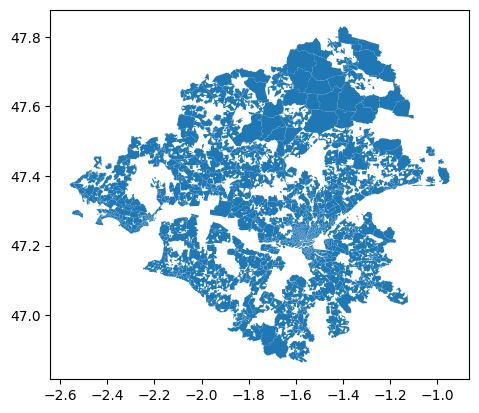

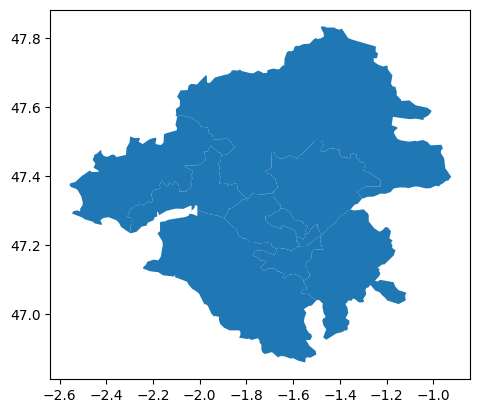

In [6]:
def aff_dep(dep):
    dep_dir = Path(f'/home/virgile/workspace/carto_legislatives_2024/départements/{dep}')
    bv_gdf = gpd.read_file(dep_dir / Path(f'bureaux_votes_{dep}.gpkg'))
    ci_gdf = gpd.read_file(dep_dir / Path(f'circonscriptions_{dep}.gpkg'))

    #bv_df = pd.read_excel(dep_dir / Path(f'{election}_bureaux_votes_{dep}.xlsx'))
    #ci_df = pd.read_excel(dep_dir / Path(f'{election}_circonscriptions_{dep}.xlsx'))

    #ci_df['ci_id'] = ci_df['ci_id'].astype(str).str.strip()
    #ci_gdf['ci_id'] = ci_gdf['ci_id'].astype(str).str.strip()
    #merged_ci = ci_gdf.merge(ci_df, on='ci_id')

    #bv_df['bv_id'] = bv_df['bv_id'].astype(str)
    #bv_gdf['bv_id'] = bv_gdf['bv_id'].astype(str)
    #merged_bv = bv_gdf.merge(bv_df, on='bv_id')
    #print(merged_ci.head())
    #print(merged_bv.head())
    
    #print(ci_df['ci_id'], ci_gdf['ci_id'])
    print(bv_gdf[~(bv_gdf.is_valid & bv_gdf.geometry.notna())])
    print(ci_gdf[~(ci_gdf.is_valid & ci_gdf.geometry.notna())])
    print(ci_gdf.unary_union.centroid)
    bv_gdf.plot()
    ci_gdf.plot()

aff_dep(44)